# SDMetrics review

Notebook to perform reviewing experiments of metrics of sdv. The goal is to check that the metrics are relevant, robust and well implemented. To do this we perform the following experiment :
* Code review : check if the metrics are well implemented.
* Real data experiment : Test if the metrics give a good score when receiving only real data.
* Correlation analysis : Study the correlations between the metrics to determine if some give the same information about the data.
* Robutness experiment : Test if the metrics value are robust, does not vary when receiving the same data.

### Packages

In [1]:
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN, TVAE
import pandas as pd
import os 
from os import path as pa
import numpy as np
import sdmetrics
metrics = sdmetrics.single_table.SingleTableMetric.get_subclasses()
import json
from tqdm.notebook import tqdm
import copy
from collections import Counter
import scipy
from preferencefig import *
from scipy.stats import chisquare,ks_2samp
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# List quality metrics (Statistical + Machine Learning Efficacy metrics)

list_metric = ['LogisticDetection','SVCDetection','BinaryDecisionTreeClassifier','BinaryAdaBoostClassifier',
'BinaryLogisticRegression','BinaryMLPClassifier','MulticlassDecisionTreeClassifier','MulticlassMLPClassifier','LinearRegression',
'MLPRegressor','GMLogLikelihood','CSTest','KSTest','KSTestExtended','ContinuousKLDivergence','DiscreteKLDivergence']

dict_metric = {}
for met in list_metric : 
    dict_metric[met] = metrics[met]

### Load datasets names

In [11]:
list_data = pd.read_csv('../Results/Result_7/Data/List_data_preprocessing2.csv',index_col=[0])

## Code review

## Identity experiment 

In [3]:
l_metric = ['LogisticDetection', 'SVCDetection', 'BinaryDecisionTreeClassifier',
       'BinaryAdaBoostClassifier', 'BinaryLogisticRegression',
       'BinaryMLPClassifier', 'MulticlassDecisionTreeClassifier',
       'MulticlassMLPClassifier', 'LinearRegression', 'MLPRegressor',
       'GMLogLikelihood', 'CSTest',  'KSTest', 'KSTestExtended',
       'ContinuousKLDivergence', 'DiscreteKLDivergence']

In [4]:
sage_table = pd.read_csv('../Results/Result_02/Data/Table_balance.csv',index_col=[0])
list_data = pd.Series(pd.read_csv('../Results/Result_7/Data/List_data_preprocessing2.csv',index_col=[0]).values.reshape(-1))
experiment = 'Result_6.json'
directory = '../T_Data/'
not_work_mod = None
#tab_data = pd.DataFrame(columns=['Dataset']+list(tt['metric']))

j = 0
for path in tqdm(list_data[:140]) : 
            f = open(directory+path+'/'+'metadata.json')
            metadata1 = json.load(f)
            f.close()

            real_data = pd.read_csv(directory+path+'/Data/'+path+'.csv',index_col=[0])
            m = np.random.permutation(len(real_data))

            real_data_1 = real_data.iloc[m[:int(0.5*len(m))]]
            real_data_2 = real_data.iloc[m[int(0.5*len(m)):]]
            tt= sdmetrics.compute_metrics(dict_metric,real_data_1,real_data_2,metadata=metadata1[path])
            if j==0 : 
                tab_data = pd.DataFrame(columns=['Dataset']+list(tt['metric']))
                tab_data.loc[j] = [path]+list(tt['normalized_score'])
                j+=1
            else : 
                prov= pd.DataFrame(columns=['Dataset']+list(tt['metric']))
                prov.loc[0] = [path]+list(tt['normalized_score'])
                tab_data = pd.concat([tab_data,prov])

  0%|          | 0/140 [00:00<?, ?it/s]

In [5]:
tab_data.dropna(1,how='all',inplace=True)
y_m = []
y_std = []
col_name = []
for c in tab_data.columns : 
    if c!='Dataset':
        y_m.append(tab_data[c].mean())
        y_std.append(tab_data[c].std())
        col_name.append(c)

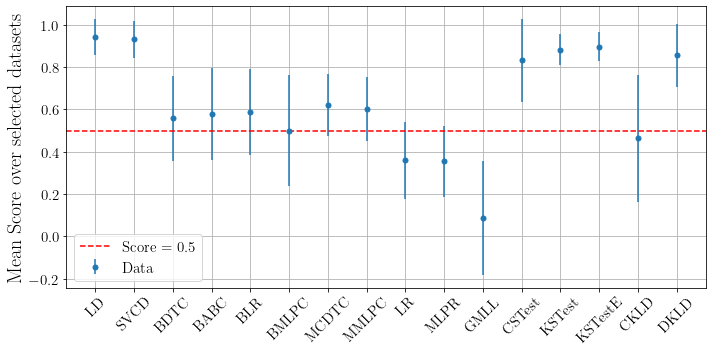

In [6]:
fig,ax = plt.subplots(figsize=(10,5))
ax.errorbar(np.arange(1,len(y_m)+1),np.array(y_m),yerr = np.array(y_std),marker='o',linestyle='',label='Data')
ax.set_xticks(np.arange(1,len(y_m)+1))
xlim = ax.get_xlim()
ax.plot([xlim[0],xlim[1]],[0.5,0.5],'--',color='red',label='Score = 0.5 ')
n_columns = ['LD','SVCD','BDTC','BABC','BLR','BMLPC','MCDTC','MMLPC','LR','MLPR','GMLL','CSTest','KSTest','KSTestE','CKLD','DKLD']
ax.set_xticklabels(n_columns)
ax.grid(True)
ax.set_ylabel('Mean Score over selected datasets')
ax.set_xlim(xlim)
plt.xticks(rotation=45)
ax.legend()
fig.savefig('../Results/Result_12/Figures/Score_real_3.jpeg',dpi=250)

## Correlation analysis

Use 'tab_data' from the previous part 'Identity experiment'.
Section just after re-generate the table

In [7]:
sage_table = pd.read_csv('../Results/Result_02/Data/Table_balance.csv',index_col=[0])
list_data = list_data_imp = pd.Series(pd.read_csv('../Results/Result_7/Data/List_data_preprocessing2.csv',index_col=[0]).values.reshape(-1))
experiment = 'Result_6.json'
directory = '../T_Data/'
not_work_mod = None
tab_data = pd.DataFrame(columns=['Dataset']+list_metric)

j = 0
for path in tqdm(list_data[:140]) : 
            f = open(directory+path+'/'+'metadata.json')
            metadata1 = json.load(f)
            f.close()

            real_data = pd.read_csv(directory+path+'/Data/'+path+'.csv',index_col=[0])
            #synt_data = pd.read_csv(directory+path+'/Data/'+path+'_GC.csv',index_col=[0])
            m = np.random.permutation(len(real_data))

            real_data_1 = real_data.iloc[m[:int(0.5*len(m))]]
            real_data_2 = real_data.iloc[m[int(0.5*len(m)):]]
            tt= sdmetrics.compute_metrics(dict_metric,real_data_1,real_data_2,metadata=metadata1[path])
            if j==0 : 
                tab_data.loc[j] = [path]+list(tt['normalized_score'])
                j+=1
            else : 
                prov= pd.DataFrame(columns=['Dataset']+list(tt['metric']))
                prov.loc[0] = [path]+list(tt['normalized_score'])
                tab_data = pd.concat([tab_data,prov])

  0%|          | 0/140 [00:00<?, ?it/s]

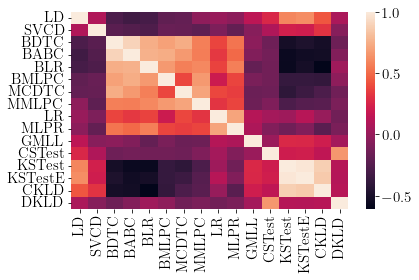

In [8]:
metrics_name = ['LD','SVCD','BDTC','BABC','BLR','BMLPC','MCDTC','MMLPC','LR','MLPR','GMLL','CSTest','KSTest','KSTestE','CKLD','DKLD']
tab_data.corr()
fig,ax = plt.subplots()
sns.heatmap(tab_data.corr(),
        xticklabels=metrics_name,
        yticklabels=metrics_name)
fig.savefig('../Results/Result_12/Figures/heatmap_2.jpeg')

## Robutness experiment

Check if the metrics give the same score when receiving the same data.  
 * To do this, for each dataset and every SDMetrics compute 30 time the score. 
 * Then compute the standard deviation of the score.  
 * Compute the mean standard deviation and the standard deviation of the score across the datasets  


In [36]:
list_metrics = ['LogisticDetection', 'SVCDetection', 'BinaryDecisionTreeClassifier',
       'BinaryAdaBoostClassifier', 'BinaryLogisticRegression',
       'BinaryMLPClassifier', 'MulticlassDecisionTreeClassifier',
       'MulticlassMLPClassifier', 'LinearRegression', 'MLPRegressor',
       'GMLogLikelihood', 'CSTest',  'KSTest', 'KSTestExtended',
       'ContinuousKLDivergence', 'DiscreteKLDivergence']
metrics = sdmetrics.single_table.SingleTableMetric.get_subclasses()
num_dataset = len(list_data)
num_met = len(list_metrics)
num_try = 30

result = np.zeros((num_dataset,num_met,num_try))
k = 0
for path in tqdm(list_data[:140]): 
    f = open(directory+'/'+path+'/'+'metadata.json') 
    metadata=json.load(f)
    f.close()

    f = open(directory+'/'+path+'/'+'dict_info.json') 
    dict_info=json.load(f)
    f.close()
    
    real_data = pd.read_csv(directory+path+'/Data/'+path+'.csv',index_col=[0])
    synthetic_data = pd.read_csv(directory+path+'/Data/'+path+'_GC.csv',index_col=[0])
    for j,met in enumerate(list_metric) : 
        dict_prov = {}
        dict_prov[met] = metrics[met]
        for i in  range(num_try) : 
            t = sdmetrics.compute_metrics(dict_prov,real_data,synthetic_data,metadata=metadata[path])
            result[k,j,i] = t['normalized_score'].iloc[0]
    k+=1

  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
result2 = result[~np.all(np.all(result == 0, axis=2),axis=1)]

### Plot robutness

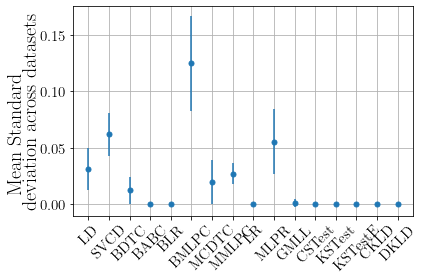

In [41]:
x_n = ['LD','SVCD','BDTC','BABC','BLR','BMLPC','MCDTC','MMLPC','LR','MLPR','GMLL','CSTest','KSTest','KSTestE','CKLD','DKLD']
x = np.arange(len(x_n))
y = np.nanmean(result2.std(axis=2),axis=0)
y_err = np.nanstd(result2.std(axis=2),axis=0)
fig,ax = plt.subplots()
ax.errorbar(x,y,yerr=y_err,marker='o',linestyle='')
ax.set_xticks(x)
ax.set_xticklabels(x_n,rotation=45)
ax.set_ylabel('Mean Standard \\newline deviation across datasets')
ax.grid(True)
fig.savefig('../Results/Result_12/Figures/MET_ROB.jpeg',dpi=250)